In [352]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder



In [353]:
df=pd.read_csv('/Users/leahnewmark/ML-Capstone/Real Breast Cancer Data.csv')

In [354]:
print(df.head())

     Patient_ID  Age  Gender  Protein1  Protein2  Protein3  Protein4  \
0  TCGA-D8-A1XD   36  FEMALE  0.080353   0.42638   0.54715  0.273680   
1  TCGA-EW-A1OX   43  FEMALE -0.420320   0.57807   0.61447 -0.031505   
2  TCGA-A8-A079   69  FEMALE  0.213980   1.31140  -0.32747 -0.234260   
3  TCGA-D8-A1XR   56  FEMALE  0.345090  -0.21147  -0.19304  0.124270   
4  TCGA-BH-A0BF   56  FEMALE  0.221550   1.90680   0.52045 -0.311990   

  Tumour_Stage                      Histology ER status PR status HER2 status  \
0          III  Infiltrating Ductal Carcinoma  Positive  Positive    Negative   
1           II             Mucinous Carcinoma  Positive  Positive    Negative   
2          III  Infiltrating Ductal Carcinoma  Positive  Positive    Negative   
3           II  Infiltrating Ductal Carcinoma  Positive  Positive    Negative   
4           II  Infiltrating Ductal Carcinoma  Positive  Positive    Negative   

                  Surgery_type Date_of_Surgery Date_of_Last_Visit  \
0  Modified

In [355]:
# Check for missing values
print("Missing values before dropna:")
print(df.isnull().sum())

# Drop rows with missing values
df.dropna(inplace=True)


Missing values before dropna:
Patient_ID             0
Age                    0
Gender                 0
Protein1               0
Protein2               0
Protein3               0
Protein4               0
Tumour_Stage           0
Histology              0
ER status              0
PR status              0
HER2 status            0
Surgery_type           0
Date_of_Surgery        0
Date_of_Last_Visit    17
Patient_Status        13
dtype: int64


In [356]:
def check_df(dataframe):
    print(" SHAPE ".center(70,'~'))
    print(dataframe.shape)
    print(" TYPES ".center(70,'~'))
    print(dataframe.dtypes)
    print(" HEAD ".center(70,'~'))
    print(dataframe.head())
    print(" DESCRIBE ".center(70,'~'))
    print(dataframe.describe().T)
check_df(df)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SHAPE ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
(317, 16)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ TYPES ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Patient_ID             object
Age                     int64
Gender                 object
Protein1              float64
Protein2              float64
Protein3              float64
Protein4              float64
Tumour_Stage           object
Histology              object
ER status              object
PR status              object
HER2 status            object
Surgery_type           object
Date_of_Surgery        object
Date_of_Last_Visit     object
Patient_Status         object
dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ HEAD ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
     Patient_ID  Age  Gender  Protein1  Protein2  Protein3  Protein4  \
0  TCGA-D8-A1XD   36  FEMALE  0.080353   0.42638   0.54715  0.273680   
1  TCGA-EW-A1OX   43  FEMALE -0.420320   0.57807   0.61447 -0.031505   
2  TCGA-A8-A079   69  FEMALE  0.213980   1.31140  -0.32747 -0.23426

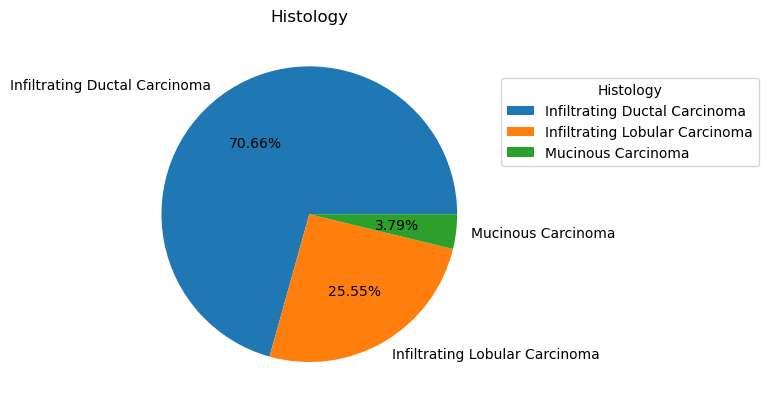

In [357]:
#histology pie chart
df['Histology'].value_counts().plot(kind='pie', autopct='%1.2f%%')
plt.title('Histology')
plt.ylabel('') #remove y label
plt.legend(title="Histology", loc="center left", bbox_to_anchor=(1,0.75))
plt.show()

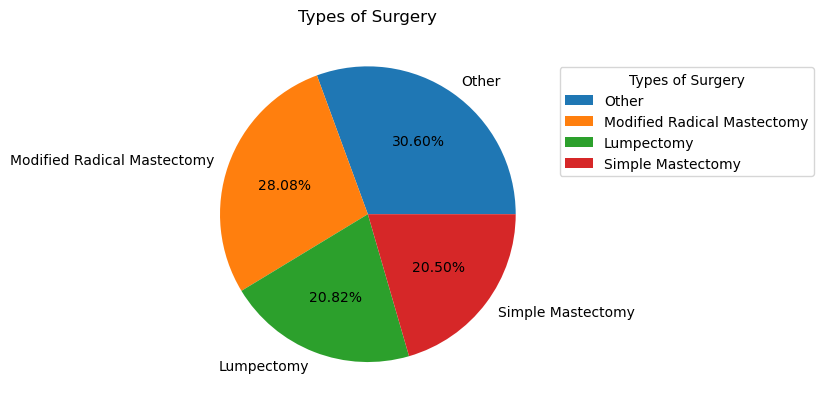

In [358]:
#Type of surgery pie chart
surgery= df['Surgery_type'].value_counts()
transactions= surgery.index
quantity= surgery.values
surgery.plot(kind='pie', autopct='%1.2f%%', title= "Types of Surgery")
plt.ylabel('')
plt.legend(title="Types of Surgery", loc="center left", bbox_to_anchor=(1,0.75))
plt.show()

In [359]:
df['Gender'].value_counts()
#Likely no need to include male pts in features, not enough sample

Gender
FEMALE    313
MALE        4
Name: count, dtype: int64

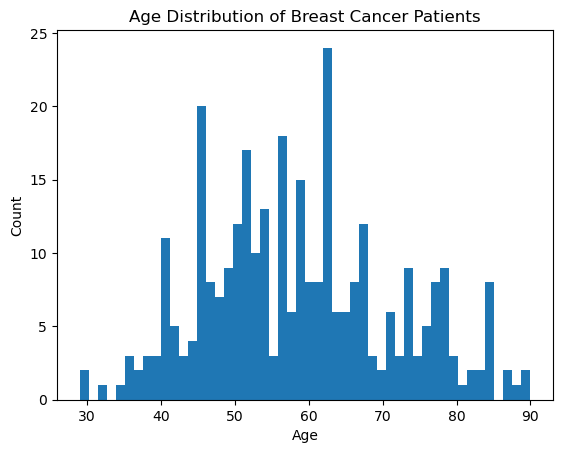

In [360]:
df['Age'].hist(bins = 50, grid = False)
plt.xlabel(xlabel = "Age")
plt.ylabel(ylabel = "Count")
plt.title("Age Distribution of Breast Cancer Patients")
plt.show()

In [361]:
# This was a good idea I picked up from alt code to create multiple pie charts or other future graphs. 

def plot_pie_chart(column, title):
    # define Seaborn color palette to use
    palette_color = sns.color_palette('bright')
  
    # plotting data on chart
    plt.pie(df[column].value_counts(), labels=df[column].unique(), colors=palette_color, autopct='%.0f%%')

    plt.title(title)
    # displaying chart
    plt.show()

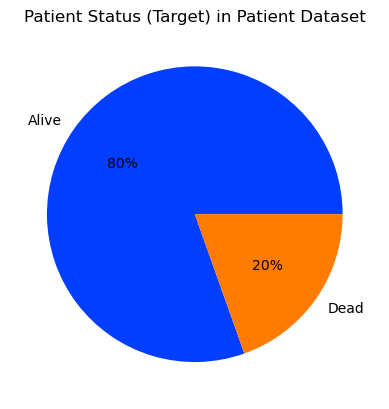

In [362]:
plot_pie_chart("Patient_Status", "Patient Status (Target) in Patient Dataset")
#my code shows 80% living pt, sample code had 79%. 

The target (living, dead) is fairly unbalanced towards patients that are alive. This would make it difficult to properly make classifications without resampling the dataset.

Preprocess 

In [363]:
#make a copy of df and drop uninformative features
df_info= df.copy().drop(columns=['Patient_ID', 'Gender', 'ER status', 'PR status'])
le= LabelEncoder()
#create target variable column
df_info['Patient_Status_le']= le.fit_transform(df_info['Patient_Status'])
df_info['HER2_Status_le'] = le.fit_transform(df_info['HER2 status'])
                            
#Ordinal encode data to keep order of categories 
oe = OrdinalEncoder(dtype=int)
df_info['Tumour_Stage_oe'] = oe.fit_transform(np.array(df_info['Tumour_Stage']).reshape(-1, 1))

df_info.drop(columns=['Tumour_Stage', 'Date_of_Surgery', 'Date_of_Last_Visit'], inplace=True)


In [364]:
df_info= pd.get_dummies(df_info, columns=['Histology'], dtype = int)

sample the data due to imbalance of dead vs living


In [365]:
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier


# Define features and target
target = df_info['Patient_Status_le']
features= df_info.drop(columns=['Patient_Status', 'Patient_Status_le', 'HER2 status', 'Surgery_type'])

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.15, random_state = 42, stratify=df_info['Patient_Status_le'])

# ## Resample dataset so that target feature is evenly distributed
smote = SMOTE(k_neighbors=5, random_state=42)

X_train, y_train = smote.fit_resample(X_train, y_train)


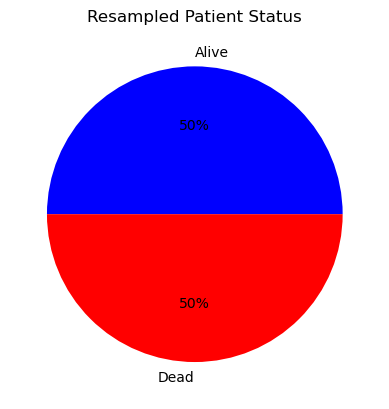

In [366]:
plt.pie(y_train.value_counts(), labels=df_info['Patient_Status'].unique(), colors='bright', autopct='%.0f%%')

plt.title("Resampled Patient Status")
# displaying chart
plt.show()

Apply SMOTE to multiple overall data x2 due to overfitting

In [367]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Determine the number of samples in each class
minority_class = y_train.min()
majority_class = y_train.max()

n_minority_samples = sum(y_train == minority_class)
n_majority_samples = sum(y_train == majority_class)

# Calculate the target number of minority class samples
augmentation_factor = 5
target_minority_samples = n_minority_samples * augmentation_factor

# Calculate sampling_strategy to get the exact number of minority samples
sampling_strategy = {minority_class: target_minority_samples}

print(f"Minority class: {minority_class}")
print(f"Majority class: {majority_class}")
print(f"Number of minority samples: {n_minority_samples}")
print(f"Number of majority samples: {n_majority_samples}")
print(f"Target minority samples: {target_minority_samples}")
print(f"Sampling strategy: {sampling_strategy}")

# Define a function to apply SMOTE with the specified sampling strategy
def apply_smote_again(X, y, sampling_strategy):
    smote = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=5, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

# Apply SMOTE to augment the dataset
X_train_augmented, y_train_augmented = apply_smote_again(X_train, y_train, sampling_strategy)


# Print the shapes to verify
print("Original X_train shape:", X_train.shape)
print("Augmented X_train shape:", X_train_augmented.shape)
print("y_train shape:", y_train.shape)
print("y_train_augmented shape:", y_train_augmented.shape)


Minority class: 0
Majority class: 1
Number of minority samples: 216
Number of majority samples: 216
Target minority samples: 1080
Sampling strategy: {0: 1080}
Original X_train shape: (432, 10)
Augmented X_train shape: (1296, 10)
y_train shape: (432,)
y_train_augmented shape: (1296,)


In [368]:
#convert y_train_augmented and X_train_augmented back to X_train and y_train
X_train = X_train_augmented
y_train = y_train_augmented

Apply Normalized scaler and Standard Scaler

In [369]:
# Add min_max scaler
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

norm = MinMaxScaler()
# Fit the scaler on the training data and transform
X_train_norm = norm.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_norm= norm.transform(X_test)

# Convert scaled arrays to DataFrames
X_train_norm_df = pd.DataFrame(X_train_norm, columns=features.columns)
X_test_norm_df = pd.DataFrame(X_test_norm, columns=features.columns)

# Normalize the data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays to DataFrames
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=features.columns)


In [370]:
# Checking the shapes of the datasets
print("X_train shape:", X_train.shape)
print("X_train_norm_df shape:", X_train_norm_df.shape)
print("X_train_scaled_df shape:", X_train_scaled_df.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (1296, 10)
X_train_norm_df shape: (1296, 10)
X_train_scaled_df shape: (1296, 10)
X_test shape: (48, 10)
y_train shape: (1296,)
y_test shape: (48,)


Support Vector Classification Model
Best estimator chosen during the fitting/GridSearch shows hyperparameters for the model

In [371]:
#was taking too long to run and was not best model in all prior test cases so commented it out.

# from sklearn.svm import SVC
# svc = SVC(probability=True)
# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10, 100]}
# clf = GridSearchCV(estimator=svc, param_grid=parameters, n_jobs=50)

# #not scaled
# clf.fit(X_train, y_train)
# clf.best_estimator_

# #normslized
# clf.fit(X_train_norm_df, y_train)
# clf.best_estimator_

# #standard scaler
# svc = SVC(probability=True)
# parameters = {'kernel': ('linear', 'rbf'), 'C': [1, 10]}
# clf = GridSearchCV(svc, parameters, n_jobs=-1)
# clf.fit(X_train_scaled_df, y_train)
# clf.fit(X_train_scaled, y_train)

# clf.best_estimator_


Logistic Regression

In [372]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define parameter grid with valid parameters for LogisticRegression
param_grid = [
    {
        'max_iter': [5000, 10000, 20000],
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['elasticnet'],
        'solver': ['saga'],
        'l1_ratio': [0, 0.5, 1]
    },
    {
        'max_iter': [5000, 10000, 20000],
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['lbfgs']  # l1_ratio is not used for l2 penalty
    }
]

# Initialize the Logistic Regression model
logit = LogisticRegression(random_state=42)

# Initialize GridSearchCV for elasticnet with scaled data
grid_search_elasticnet_scaled = GridSearchCV(logit, param_grid, cv=5, scoring='f1', n_jobs=-1, error_score='raise')
try:
    grid_search_elasticnet_scaled.fit(X_train_scaled_df, y_train)
    print("ElasticNet (Scaled Data):")
    print(f"Best Parameters: {grid_search_elasticnet_scaled.best_params_}")
    print(f"Best F1 Score: {grid_search_elasticnet_scaled.best_score_}")
except Exception as e:
    print(f"Error during ElasticNet (Scaled Data) GridSearchCV: {e}")

# Initialize GridSearchCV for elasticnet with normalized data
grid_search_elasticnet_normal = GridSearchCV(logit, param_grid, cv=5, scoring='f1', n_jobs=-1, error_score='raise')
try:
    grid_search_elasticnet_normal.fit(X_train_norm_df, y_train)
    print("ElasticNet (Normalized Data):")
    print(f"Best Parameters: {grid_search_elasticnet_normal.best_params_}")
    print(f"Best F1 Score: {grid_search_elasticnet_normal.best_score_}")
except Exception as e:
    print(f"Error during ElasticNet (Normalized Data) GridSearchCV: {e}")


ElasticNet (Scaled Data):
Best Parameters: {'C': 10, 'max_iter': 5000, 'penalty': 'l2', 'solver': 'lbfgs'}
Best F1 Score: 0.01509433962264151
ElasticNet (Normalized Data):
Best Parameters: {'C': 0.01, 'l1_ratio': 0, 'max_iter': 5000, 'penalty': 'elasticnet', 'solver': 'saga'}
Best F1 Score: 0.0


Logistic regression with updated parameters from 3500 to 5000 and l1_ratio= 0.5, l1_ratio has lesser impact on the F1 score  compared to increasing max_iter. Normalized data works best in logistic regression but still low F1 score

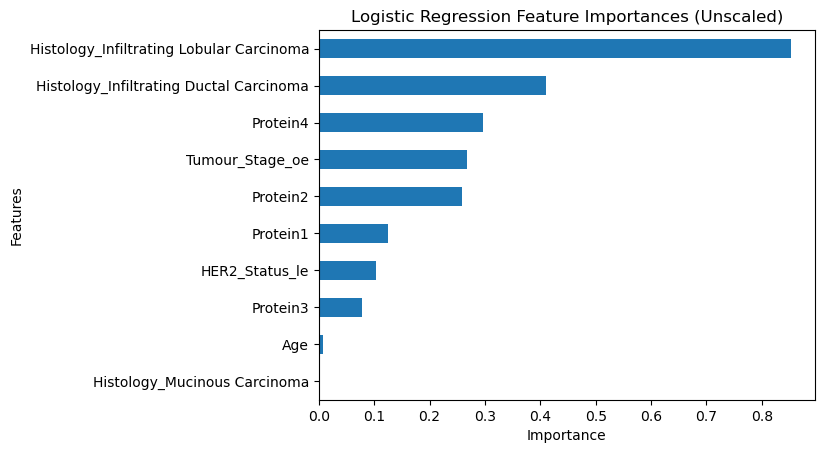

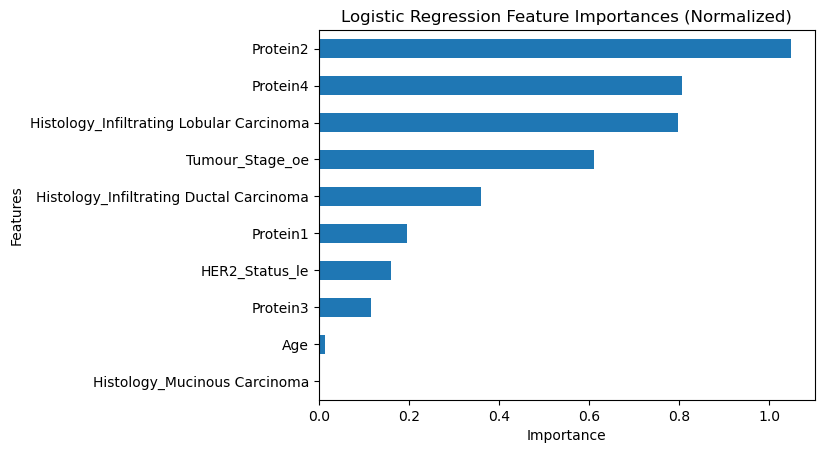

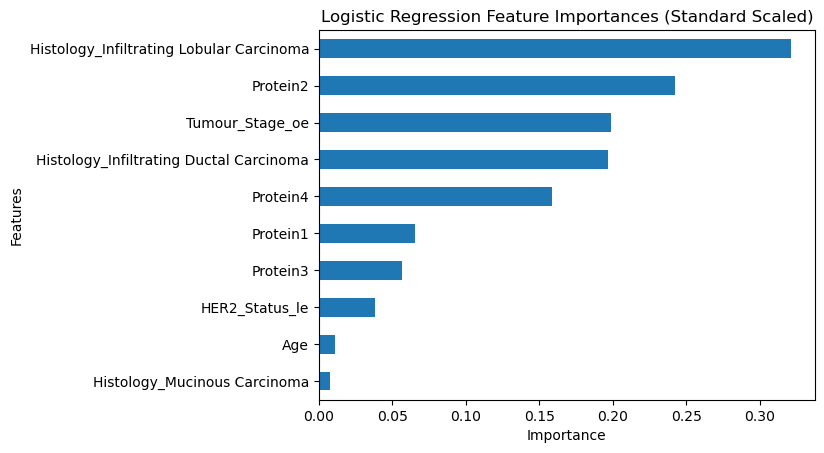

In [373]:
logit = LogisticRegression(max_iter=5000, penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=42)
logit.fit(X_train, y_train)
logit_importances = logit.coef_[0]
logit_feature_importances = pd.Series(index=original_column_names, data=np.abs(logit_importances))
logit_feature_importances = logit_feature_importances.sort_values(ascending=True)
logit_feature_importances.plot(kind='barh', title='Logistic Regression Feature Importances (Unscaled)', xlabel='Importance', ylabel='Features')
plt.show()

# Logistic Regression with normalized data
logit.fit(X_train_norm_df, y_train)
logit_importances = logit.coef_[0]
logit_feature_importances_norm = pd.Series(index=original_column_names, data=np.abs(logit_importances))
logit_feature_importances_norm = logit_feature_importances_norm.sort_values(ascending=True)
logit_feature_importances_norm.plot(kind='barh', title='Logistic Regression Feature Importances (Normalized)', xlabel='Importance', ylabel='Features')
plt.show()

# Logistic Regression with scaled data
logit.fit(X_train_scaled_df, y_train)
logit_importances = logit.coef_[0]
logit_feature_importances_scaled = pd.Series(index=original_column_names, data=np.abs(logit_importances))
logit_feature_importances_scaled = logit_feature_importances_scaled.sort_values(ascending=True)
logit_feature_importances_scaled.plot(kind='barh', title='Logistic Regression Feature Importances (Standard Scaled)', xlabel='Importance', ylabel='Features')
plt.show()

Per origincal author: Following training of the Logisitic Regression model on the dataset, the most important features that contribute to classification of Patient Status include Histology of ILC, IDC carcinomas and patient is HER2+/-. Features that don't seem to contribute to the model's prediction include age, stage of tumour. Suprisingly, the stage of a tumour does not seem to contribute much informationally to the model, despite domain knowledge of this feature. This may be due to skewness of the data towards stage III cancer as this is prevalent in ~60% of the patients in the dataset. HER2 status also is a informative input feature for the model as we understand by HER2++ typically as a predictor of cancer cases.

Random Forest Classifier

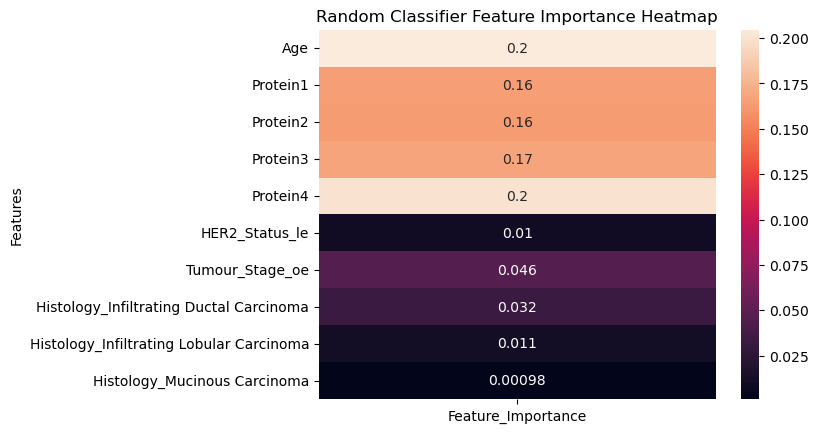

Normalized RC Heat map
RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=500,
                       random_state=42)


In [374]:
forest = RandomForestClassifier(n_estimators=500)
forest.fit(X_train, y_train)
forest_feature_importance = pd.DataFrame(index = forest.feature_names_in_, data=forest.feature_importances_, columns = ['Feature_Importance'])
sns.heatmap(forest_feature_importance, annot=True).set(title = "Random Classifier Feature Importance Heatmap", ylabel='Features')
plt.show()

print( "Normalized RC Heat map")
# Initialize the RandomForestClassifier with 500 estimators
forest = RandomForestClassifier(n_estimators=500, random_state=42)

# Fit the model using the normalized training data
forest.fit(X_train_norm_df, y_train)

# Create a DataFrame for feature importances
forest_feature_importance = pd.DataFrame(
    index=original_column_names,  # Ensure these match the features used for fitting
    data=forest.feature_importances_,
    columns=['Feature_Importance']
)

#check best parameters
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30],
    'class_weight': ['balanced', None]  # Use balanced to handle class imbalance
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1)
grid_search.fit(X_train_scaled_df, y_train)

best_model_scaled = grid_search.best_estimator_
print(best_model_scaled)

# Random Forest Classifier scaled
forest = RandomForestClassifier(n_estimators=500, random_state=42)
forest.fit(X_train_scaled_df, y_train)

from sklearn.model_selection import cross_val_score

# Cross-validation for RandomForest
cv_scores = cross_val_score(RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=42), X_train_scaled_df, y_train, cv=5, scoring='f1')
print(f"Cross-Validation F1 Scores: {cv_scores}")
print(f"Mean F1 Score: {cv_scores.mean()}")

My output is in line with original authors output, showing age and protein and most important features for survival prediction. 

Decison Tree Classifier

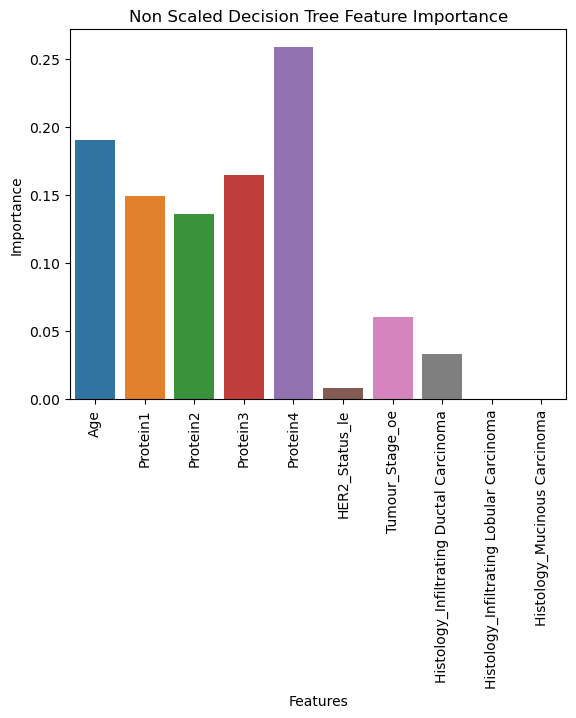

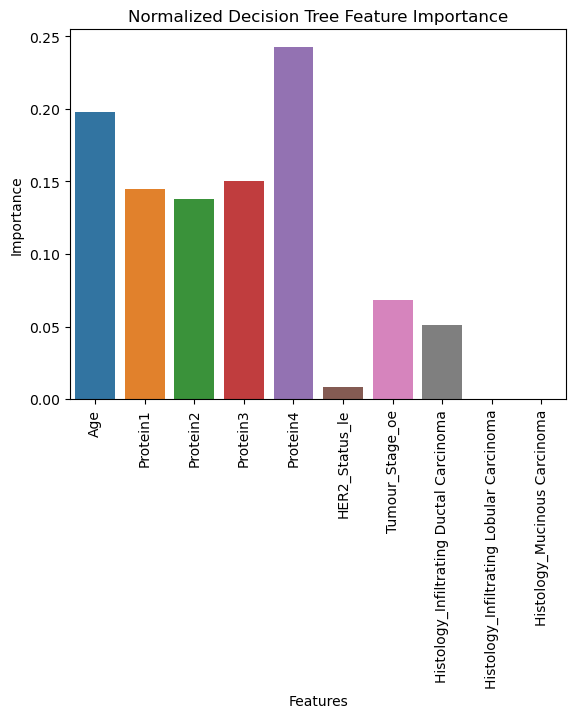

DecisionTreeClassifier(max_depth=15)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree_gini = DecisionTreeClassifier(criterion='gini',max_depth=15)
tree_gini.fit(X_train, y_train)
tree_gini_feature_importances = pd.Series(tree_gini.feature_importances_, index=tree_gini.feature_names_in_)

sns.barplot(x = tree_gini.feature_names_in_, y = tree_gini.feature_importances_).set(title = "Non Scaled Decision Tree Feature Importance", xlabel='Features', ylabel='Importance')
plt.xticks(rotation = 90) 
plt.show()

# normalized decision tree
# Initialize and fit the Decision Tree Classifier
tree_gini = DecisionTreeClassifier(criterion='gini', max_depth=15)
tree_gini.fit(X_train_norm_df, y_train)

# Create a DataFrame for feature importances
tree_gini_feature_importances = pd.Series(
    tree_gini.feature_importances_,
    index=original_column_names  # Use the original column names
)

# Plot the feature importances as a bar plot
sns.barplot(x=tree_gini_feature_importances.index, y=tree_gini_feature_importances.values).set(
    title="Normalized Decision Tree Feature Importance",
    xlabel='Features',
    ylabel='Importance'
)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

# Decision Tree Classifier scaled
tree_gini = DecisionTreeClassifier(criterion='gini', max_depth=15)
tree_gini.fit(X_train_scaled_df, y_train)

HER2 status le is empty in my code when compared to original author's code. This could be counting for the descrepency. Per original author "Both decision tree classifiers (Decision Tree and Random Forest) produce similar rankings for the importance of the features in the models. Protein 2 expression levels seems to be a driving factor to the classification of patient status, with the other proteins also contributing to the predictions of the model. Opposing to what previously was found from our Logistic Regressor training is that age also contributes to the predictions of the model--this matches to preconceived notion that age also can be a determinant of the patient's outcome with the disease. Interestingly, the lowest scored features for importance are presence of specific carcinoma's (ILC, IDC, MC), HER2 status and stage of the tumour."

In [ ]:
# Define cross-validation function
def perform_cross_validation(model, X, y, model_name):
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='f1')
    print(f"Cross-Validation F1 Scores for {model_name}: {cv_scores}")
    print(f"Mean F1 Score for {model_name}: {cv_scores.mean()}")

print("Decision Tree with Unscaled Data:")
perform_cross_validation(tree_gini, X_train, y_train, "Decision Tree with Unscaled Data")

print("\nDecision Tree with Normalized Data:")
perform_cross_validation(tree_gini, X_train_norm_df, y_train, "Decision Tree with Normalized Data")

print("\nDecision Tree with Scaled Data:")
perform_cross_validation(tree_gini, X_train_scaled_df, y_train, "Decision Tree with Scaled Data")

print("\nLogistic Regression with Unscaled Data:")
perform_cross_validation(logit, X_train, y_train, "Logistic Regression with Unscaled Data")

print("\nLogistic Regression with Normalized Data:")
perform_cross_validation(logit, X_train_norm_df, y_train, "Logistic Regression with Normalized Data")

print("\nLogistic Regression with Scaled Data:")
perform_cross_validation(logit, X_train_scaled_df, y_train, "Logistic Regression with Scaled Data")

print("\nRandom Forest with Unscaled Data:")
perform_cross_validation(forest, X_train, y_train, "Random Forest with Unscaled Data")

print("\nRandom Forest with Normalized Data:")
perform_cross_validation(forest, X_train_norm_df, y_train, "Random Forest with Normalized Data")

print("\nRandom Forest with Scaled Data:")
perform_cross_validation(forest, X_train_scaled_df, y_train, "Random Forest with Scaled Data")

Decision Tree with Unscaled Data:
Cross-Validation F1 Scores for Decision Tree with Unscaled Data: [0.5952381  0.61538462 0.69047619 0.51851852 0.58064516]
Mean F1 Score for Decision Tree with Unscaled Data: 0.6000525161815484

Decision Tree with Normalized Data:
Cross-Validation F1 Scores for Decision Tree with Normalized Data: [0.63529412 0.63157895 0.65853659 0.51851852 0.55913978]
Mean F1 Score for Decision Tree with Normalized Data: 0.6006135907692177

Decision Tree with Scaled Data:
Cross-Validation F1 Scores for Decision Tree with Scaled Data: [0.66666667 0.58666667 0.63529412 0.53164557 0.59574468]
Mean F1 Score for Decision Tree with Scaled Data: 0.6032035402903418

Logistic Regression with Unscaled Data:
Cross-Validation F1 Scores for Logistic Regression with Unscaled Data: [0. 0. 0. 0. 0.]
Mean F1 Score for Logistic Regression with Unscaled Data: 0.0

Logistic Regression with Normalized Data:
Cross-Validation F1 Scores for Logistic Regression with Normalized Data: [0. 0. 0. 

In [ ]:
 
def plot_ROC(model, title, X, Y): 
    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_true=Y, y_score=model.predict_proba(X)[:, 1])
    roc_auc = roc_auc_score(y_true=Y, y_score=model.predict_proba(X)[:, 1])
    plt.plot(fpr, tpr, color="blue", label="AUC = %0.3f" % roc_auc)
    plt.plot([0, 1], [0, 1], color="red", linestyle="--", lw=1)
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()


Future analysis using ROC curves on models- would like to discuss these curves

def plot_ROC(model, title, X, Y): 
    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_true=Y, y_score=model.predict_proba(X)[:, 1])
    roc_auc = roc_auc_score(y_true=Y, y_score=model.predict_proba(X)[:, 1])
    plt.plot(fpr, tpr, color="blue", label="AUC = %0.3f" % roc_auc)
    plt.plot([0, 1], [0, 1], color="red", linestyle="--", lw=1)
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

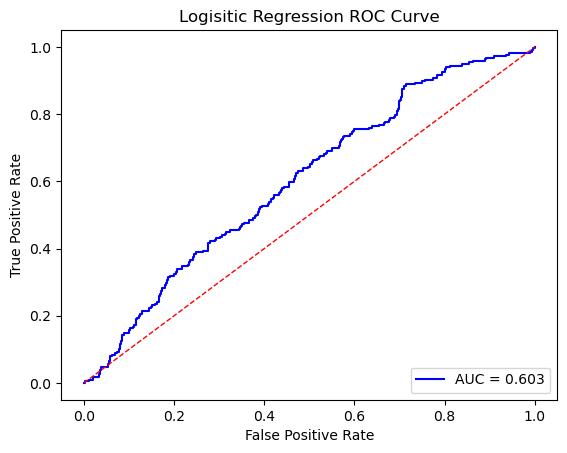

Accuracy Score: 0.8333333333333334
Confusion Matrix:
 [[1080    0]
 [ 216    0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91      1080
           1       0.00      0.00      0.00       216

    accuracy                           0.83      1296
   macro avg       0.42      0.50      0.45      1296
weighted avg       0.69      0.83      0.76      1296



/Users/leahnewmark/Python_VS/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/leahnewmark/Python_VS/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/leahnewmark/Python_VS/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

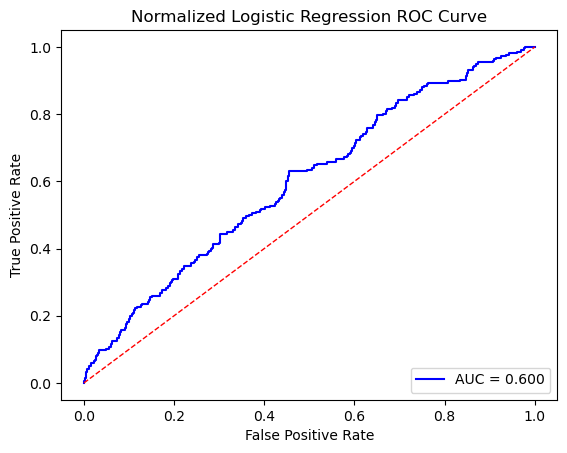

Accuracy Score: 0.8333333333333334
Confusion Matrix:
 [[1080    0]
 [ 216    0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91      1080
           1       0.00      0.00      0.00       216

    accuracy                           0.83      1296
   macro avg       0.42      0.50      0.45      1296
weighted avg       0.69      0.83      0.76      1296



/Users/leahnewmark/Python_VS/.conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/leahnewmark/Python_VS/.conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/leahnewmark/Python_VS/.conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/leahnewmark/Python_VS/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/leahnewmark/Python_VS/.conda/lib/

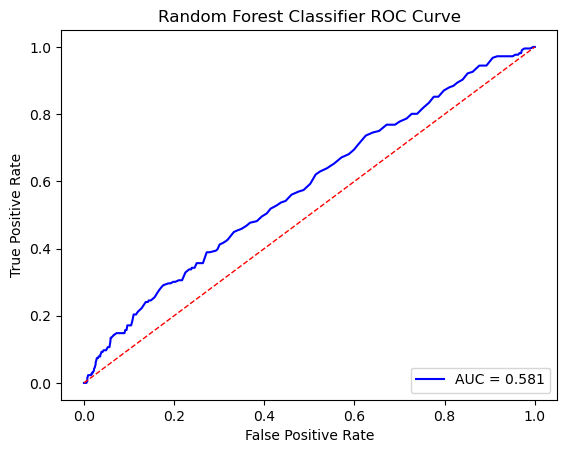

Accuracy Score: 0.8333333333333334
Confusion Matrix:
 [[1080    0]
 [ 216    0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91      1080
           1       0.00      0.00      0.00       216

    accuracy                           0.83      1296
   macro avg       0.42      0.50      0.45      1296
weighted avg       0.69      0.83      0.76      1296



/Users/leahnewmark/Python_VS/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/leahnewmark/Python_VS/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/leahnewmark/Python_VS/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

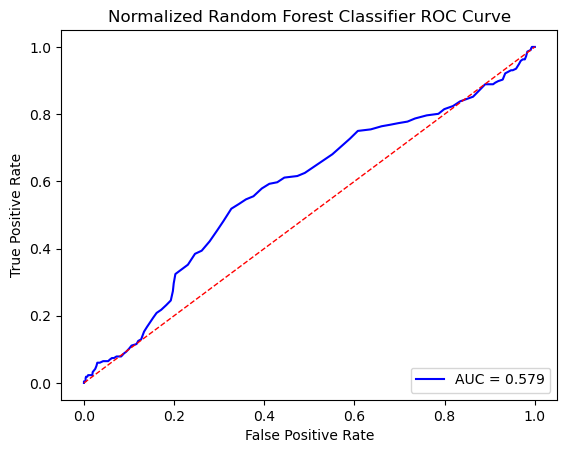

Accuracy Score: 0.8333333333333334
Confusion Matrix:
 [[1080    0]
 [ 216    0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91      1080
           1       0.00      0.00      0.00       216

    accuracy                           0.83      1296
   macro avg       0.42      0.50      0.45      1296
weighted avg       0.69      0.83      0.76      1296



/Users/leahnewmark/Python_VS/.conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/leahnewmark/Python_VS/.conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/leahnewmark/Python_VS/.conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/leahnewmark/Python_VS/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/leahnewmark/Python_VS

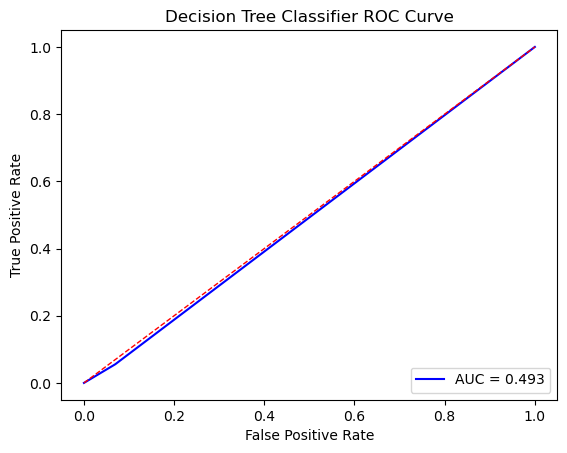

/Users/leahnewmark/Python_VS/.conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/leahnewmark/Python_VS/.conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Accuracy Score: 0.7847222222222222
Confusion Matrix:
 [[1005   75]
 [ 204   12]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.93      0.88      1080
           1       0.14      0.06      0.08       216

    accuracy                           0.78      1296
   macro avg       0.48      0.49      0.48      1296
weighted avg       0.72      0.78      0.74      1296



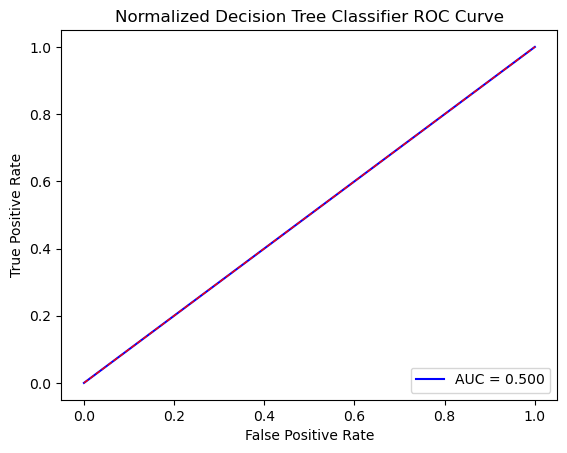

Accuracy Score: 0.8333333333333334
Confusion Matrix:
 [[1080    0]
 [ 216    0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91      1080
           1       0.00      0.00      0.00       216

    accuracy                           0.83      1296
   macro avg       0.42      0.50      0.45      1296
weighted avg       0.69      0.83      0.76      1296



/Users/leahnewmark/Python_VS/.conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/leahnewmark/Python_VS/.conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/leahnewmark/Python_VS/.conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/leahnewmark/Python_VS/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/leahnewmark/Python_VS

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, classification_report
# Performance on training data
plot_ROC(logit, "Logisitic Regression ROC Curve", X_train, y_train)
print(f"Accuracy Score: {accuracy_score(y_true=y_train, y_pred=logit.predict(X_train))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_train, y_pred=logit.predict(X_train))}")
print(f"Classification Report:\n {classification_report(y_true=y_train, y_pred=logit.predict(X_train))}")

# Performance on training data with Logistic Regression
plot_ROC(logit, "Normalized Logistic Regression ROC Curve", X_train_norm, y_train)
print(f"Accuracy Score: {accuracy_score(y_true=y_train, y_pred=logit.predict(X_train_norm))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_train, y_pred=logit.predict(X_train_norm))}")
print(f"Classification Report:\n {classification_report(y_true=y_train, y_pred=logit.predict(X_train_norm))}")


# plot_ROC(clf, "Support Vector Machine Classifier ROC Curve", X_train, y_train)
# print(f"Accuracy Score: {accuracy_score(y_true=y_train, y_pred=clf.predict(X_train))}")
# print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_train, y_pred=clf.predict(X_train))}")
# print(f"Classification Report:\n {classification_report(y_true=y_train, y_pred=clf.predict(X_train))}")

# # Performance on training data with Support Vector Machine
# plot_ROC(clf.best_estimator_, "Normalized Support Vector Machine ROC Curve", X_train_norm, y_train)
# print(f"Accuracy Score: {accuracy_score(y_true=y_train, y_pred=clf.best_estimator_.predict(X_train_norm))}")
# print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_train, y_pred=clf.best_estimator_.predict(X_train_norm))}")
# print(f"Classification Report:\n {classification_report(y_true=y_train, y_pred=clf.best_estimator_.predict(X_train_norm))}")


plot_ROC(forest, "Random Forest Classifier ROC Curve", X_train, y_train)
print(f"Accuracy Score: {accuracy_score(y_true=y_train, y_pred=forest.predict(X_train))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_train, y_pred=forest.predict(X_train))}")
print(f"Classification Report:\n {classification_report(y_true=y_train, y_pred=forest.predict(X_train))}")

# Performance on training data with Random Forest
plot_ROC(forest, "Normalized Random Forest Classifier ROC Curve", X_train_norm, y_train)
print(f"Accuracy Score: {accuracy_score(y_true=y_train, y_pred=forest.predict(X_train_norm))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_train, y_pred=forest.predict(X_train_norm))}")
print(f"Classification Report:\n {classification_report(y_true=y_train, y_pred=forest.predict(X_train_norm))}")


plot_ROC(tree_gini, "Decision Tree Classifier ROC Curve", X_train, y_train)
print(f"Accuracy Score: {accuracy_score(y_true=y_train, y_pred=tree_gini.predict(X_train))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_train, y_pred=tree_gini.predict(X_train))}")
print(f"Classification Report:\n {classification_report(y_true=y_train, y_pred=tree_gini.predict(X_train))}")

# Performance on training data with Decision Tree
plot_ROC(tree_gini, "Normalized Decision Tree Classifier ROC Curve", X_train_norm, y_train)
print(f"Accuracy Score: {accuracy_score(y_true=y_train, y_pred=tree_gini.predict(X_train_norm))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_train, y_pred=tree_gini.predict(X_train_norm))}")
print(f"Classification Report:\n {classification_report(y_true=y_train, y_pred=tree_gini.predict(X_train_norm))}")

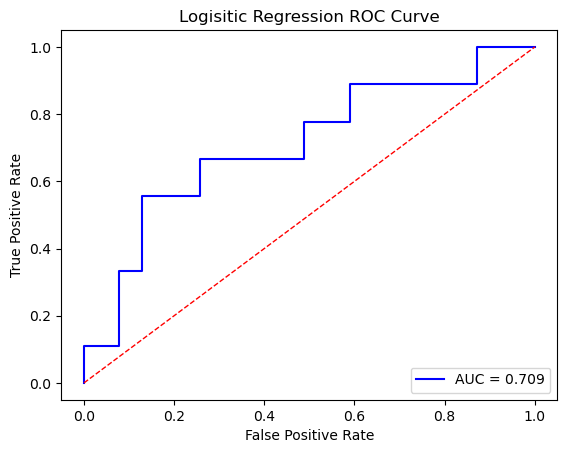

Accuracy Score: 0.8125
Confusion Matrix:
 [[39  0]
 [ 9  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.90        39
           1       0.00      0.00      0.00         9

    accuracy                           0.81        48
   macro avg       0.41      0.50      0.45        48
weighted avg       0.66      0.81      0.73        48



/Users/leahnewmark/Python_VS/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/leahnewmark/Python_VS/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/leahnewmark/Python_VS/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

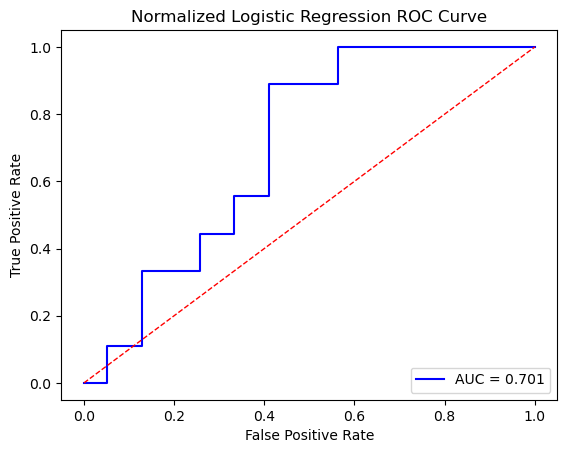

Accuracy Score: 0.8125
Confusion Matrix:
 [[39  0]
 [ 9  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.90        39
           1       0.00      0.00      0.00         9

    accuracy                           0.81        48
   macro avg       0.41      0.50      0.45        48
weighted avg       0.66      0.81      0.73        48



/Users/leahnewmark/Python_VS/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/leahnewmark/Python_VS/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/leahnewmark/Python_VS/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

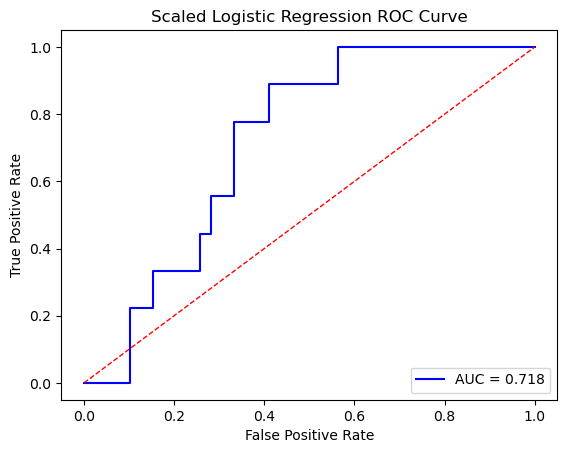

/Users/leahnewmark/Python_VS/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/leahnewmark/Python_VS/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/leahnewmark/Python_VS/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

Accuracy Score: 0.8125
Confusion Matrix:
 [[39  0]
 [ 9  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.90        39
           1       0.00      0.00      0.00         9

    accuracy                           0.81        48
   macro avg       0.41      0.50      0.45        48
weighted avg       0.66      0.81      0.73        48



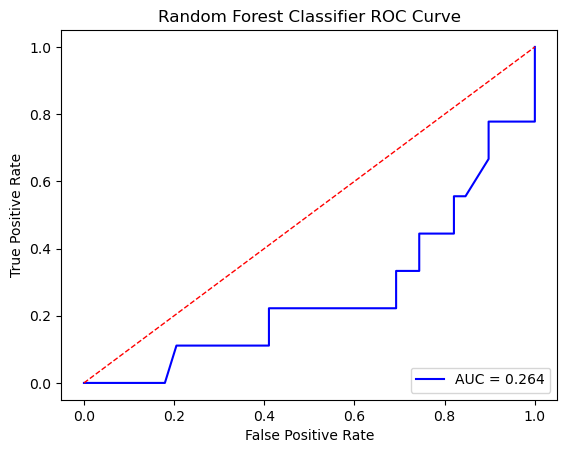

Accuracy Score: 0.8125
Confusion Matrix:
 [[39  0]
 [ 9  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.90        39
           1       0.00      0.00      0.00         9

    accuracy                           0.81        48
   macro avg       0.41      0.50      0.45        48
weighted avg       0.66      0.81      0.73        48



/Users/leahnewmark/Python_VS/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/leahnewmark/Python_VS/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/leahnewmark/Python_VS/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

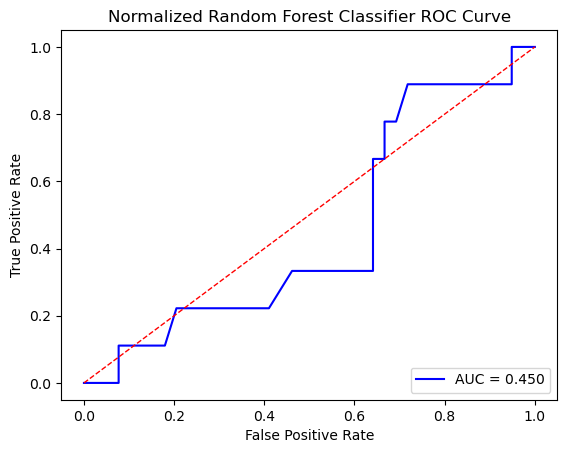

Accuracy Score: 0.8125
Confusion Matrix:
 [[39  0]
 [ 9  0]]


/Users/leahnewmark/Python_VS/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.90        39
           1       0.00      0.00      0.00         9

    accuracy                           0.81        48
   macro avg       0.41      0.50      0.45        48
weighted avg       0.66      0.81      0.73        48



/Users/leahnewmark/Python_VS/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/leahnewmark/Python_VS/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


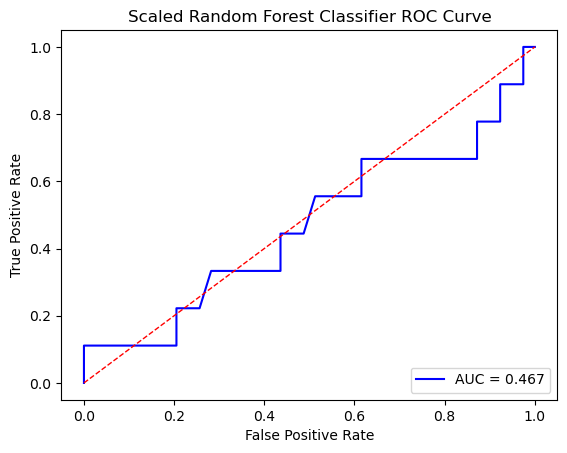

Accuracy Score: 0.8333333333333334
Confusion Matrix:
 [[39  0]
 [ 8  1]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        39
           1       1.00      0.11      0.20         9

    accuracy                           0.83        48
   macro avg       0.91      0.56      0.55        48
weighted avg       0.86      0.83      0.77        48



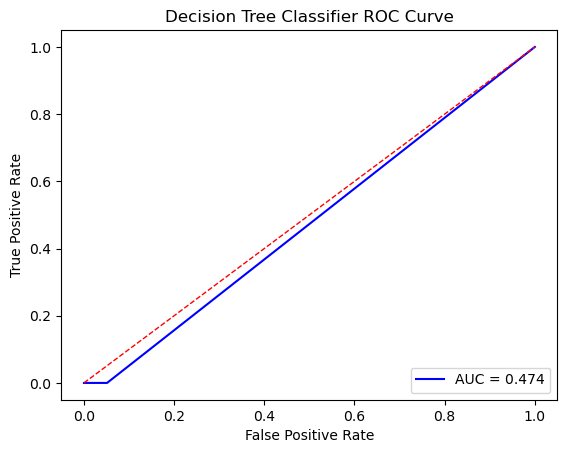

Accuracy Score: 0.7708333333333334
Confusion Matrix:
 [[37  2]
 [ 9  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.95      0.87        39
           1       0.00      0.00      0.00         9

    accuracy                           0.77        48
   macro avg       0.40      0.47      0.44        48
weighted avg       0.65      0.77      0.71        48



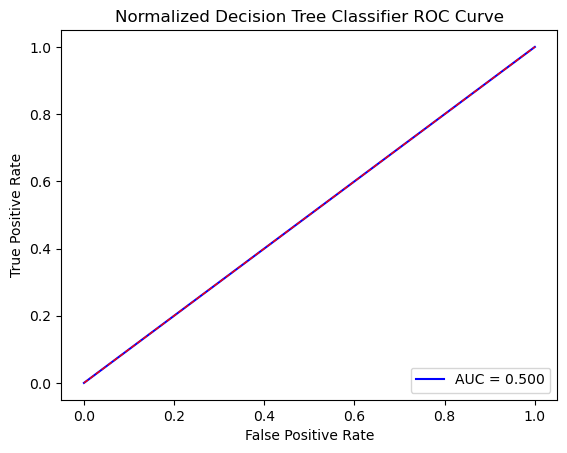

/Users/leahnewmark/Python_VS/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/leahnewmark/Python_VS/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/leahnewmark/Python_VS/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

Accuracy Score: 0.8125
Confusion Matrix:
 [[39  0]
 [ 9  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.90        39
           1       0.00      0.00      0.00         9

    accuracy                           0.81        48
   macro avg       0.41      0.50      0.45        48
weighted avg       0.66      0.81      0.73        48



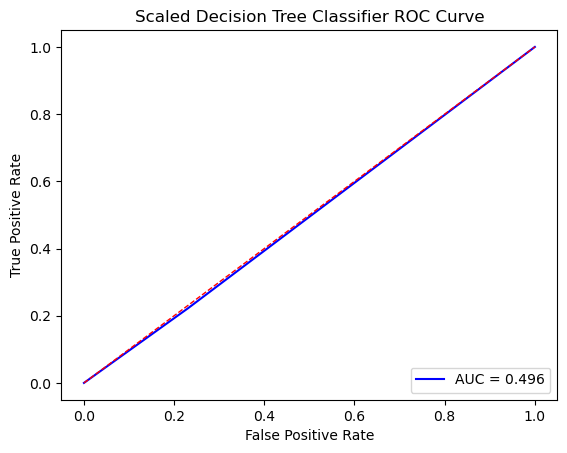

Accuracy Score: 0.6666666666666666
Confusion Matrix:
 [[30  9]
 [ 7  2]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.77      0.79        39
           1       0.18      0.22      0.20         9

    accuracy                           0.67        48
   macro avg       0.50      0.50      0.49        48
weighted avg       0.69      0.67      0.68        48



In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, classification_report
# Performance on training data
plot_ROC(logit, "Logisitic Regression ROC Curve", X_test, y_test)
print(f"Accuracy Score: {accuracy_score(y_true=y_test, y_pred=logit.predict(X_test))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_test, y_pred=logit.predict(X_test))}")
print(f"Classification Report:\n {classification_report(y_true=y_test, y_pred=logit.predict(X_test))}")

# Performance on testing data with Logistic Regression
plot_ROC(logit, "Normalized Logistic Regression ROC Curve", X_test_norm_df, y_test)
print(f"Accuracy Score: {accuracy_score(y_true=y_test, y_pred=logit.predict(X_test_norm_df))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_test, y_pred=logit.predict(X_test_norm_df))}")
print(f"Classification Report:\n {classification_report(y_true=y_test, y_pred=logit.predict(X_test_norm_df))}")

# Logistic Regression Scaled
plot_ROC(logit, "Scaled Logistic Regression ROC Curve", X_test_scaled_df, y_test)
print(f"Accuracy Score: {accuracy_score(y_true=y_test, y_pred=logit.predict(X_test_scaled_df))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_test, y_pred=logit.predict(X_test_scaled_df))}")
print(f"Classification Report:\n {classification_report(y_true=y_test, y_pred=logit.predict(X_test_scaled_df))}")


# plot_ROC(clf, "Support Vector Machine Classifier ROC Curve", X_test, y_test)
# print(f"Accuracy Score: {accuracy_score(y_true=y_test, y_pred=clf.predict(X_test))}")
# print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_test, y_pred=clf.predict(X_test))}")
# print(f"Classification Report:\n {classification_report(y_true=y_test, y_pred=clf.predict(X_test))}")

# # Performance on testing data with Support Vector Machine
# plot_ROC(clf.best_estimator_, "Normalized Support Vector Machine Classifier ROC Curve", X_test_norm_df, y_test)
# print(f"Accuracy Score: {accuracy_score(y_true=y_test, y_pred=clf.best_estimator_.predict(X_test_norm_df))}")
# print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_test, y_pred=clf.best_estimator_.predict(X_test_norm_df))}")
# print(f"Classification Report:\n {classification_report(y_true=y_test, y_pred=clf.best_estimator_.predict(X_test_norm_df))}")

# # Support Vector Machine Scaled
# plot_ROC(clf.best_estimator_, "Scaled Support Vector Machine Classifier ROC Curve", X_test_scaled_df, y_test)
# print(f"Accuracy Score: {accuracy_score(y_true=y_test, y_pred=clf.best_estimator_.predict(X_test_scaled_df))}")
# print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_test, y_pred=clf.best_estimator_.predict(X_test_scaled_df))}")
# print(f"Classification Report:\n {classification_report(y_true=y_test, y_pred=clf.best_estimator_.predict(X_test_scaled_df))}")



plot_ROC(forest, "Random Forest Classifier ROC Curve",  X_test, y_test)
print(f"Accuracy Score: {accuracy_score(y_true=y_test, y_pred=forest.predict(X_test))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_test, y_pred=forest.predict(X_test))}")
print(f"Classification Report:\n {classification_report(y_true=y_test, y_pred=forest.predict(X_test))}")

# Performance on testing data with Random Forest
plot_ROC(forest, "Normalized Random Forest Classifier ROC Curve", X_test_norm, y_test)
print(f"Accuracy Score: {accuracy_score(y_true=y_test, y_pred=forest.predict(X_test_norm_df))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_test, y_pred=forest.predict(X_test_norm_df))}")
print(f"Classification Report:\n {classification_report(y_true=y_test, y_pred=forest.predict(X_test_norm_df))}")

# Random Forest
plot_ROC(forest, "Scaled Random Forest Classifier ROC Curve", X_test_scaled_df, y_test)
print(f"Accuracy Score: {accuracy_score(y_true=y_test, y_pred=forest.predict(X_test_scaled_df))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_test, y_pred=forest.predict(X_test_scaled_df))}")
print(f"Classification Report:\n {classification_report(y_true=y_test, y_pred=forest.predict(X_test_scaled_df))}")


plot_ROC(tree_gini, "Decision Tree Classifier ROC Curve",  X_test, y_test)
print(f"Accuracy Score: {accuracy_score(y_true=y_test, y_pred=tree_gini.predict(X_test))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_test, y_pred=tree_gini.predict(X_test))}")
print(f"Classification Report:\n {classification_report(y_true=y_test, y_pred=tree_gini.predict(X_test))}")

# Performance on testing data with Decision Tree
plot_ROC(tree_gini, "Normalized Decision Tree Classifier ROC Curve", X_test_norm_df, y_test)
print(f"Accuracy Score: {accuracy_score(y_true=y_test, y_pred=tree_gini.predict(X_test_norm_df))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_test, y_pred=tree_gini.predict(X_test_norm_df))}")
print(f"Classification Report:\n {classification_report(y_true=y_test, y_pred=tree_gini.predict(X_test_norm_df))}")

# Decision Tree scaled
plot_ROC(tree_gini, "Scaled Decision Tree Classifier ROC Curve", X_test_scaled_df, y_test)
print(f"Accuracy Score: {accuracy_score(y_true=y_test, y_pred=tree_gini.predict(X_test_scaled_df))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_test, y_pred=tree_gini.predict(X_test_scaled_df))}")
print(f"Classification Report:\n {classification_report(y_true=y_test, y_pred=tree_gini.predict(X_test_scaled_df))}")



Curves showing stair set could indicate that we are overfitting on small amount of data and need more samples. 

Logistic regression classification report: Precision- out of all the features that the model predicted were coorelated with cancer only 31% of them were actually coorelated, recall- out of all the features that actually were associated with cancer the model predicted this outcome correctly 44% of the time, f1-score was 36. This model does a poor job. 
It still is above the ROC curve. 

Support vector  machine was worse followed by random forest and then decision tree. 

This is suggestive of overfitting. Our test set is 15% of the data. Data Augmentation may be required. 

In [ ]:
# we need to specify oob_score = True to be able to calculate OOB error
import sklearn.ensemble
import sklearn.metrics

model = sklearn.ensemble.RandomForestRegressor(100, min_samples_leaf=100)
model.fit(X_train, y_train)

print(sklearn.metrics.mean_absolute_error(model.predict(X_test), y_test))
0.5592536196736408

model = sklearn.ensemble.RandomForestRegressor(100, min_samples_leaf=100, 
     oob_score=True)

model.fit(X_train, y_train)

# error for test set
print(sklearn.metrics.mean_absolute_error(model.predict(X_test), y_test))
0.5592536196736408

# error for training set
print(sklearn.metrics.mean_absolute_error(model.predict(X_train), y_train))
0.5430398596179975

# out-of-bag error
print(sklearn.metrics.mean_absolute_error(model.oob_prediction_, y_train))
0.5571191870008492

0.3029997880719287
0.29973834509283115
0.2635933669309736
0.2692039744076828


0.5571191870008492

Conclusion:

Standard scaler improves accurance on test set for random forest and this is the only model that shows improvements in accuracy once scaler is applied. 

Normalized scaler improves accuracy only negligably, on logistic regression. 

Normalizing decision tree puts more AUC and improves precision but accuracy is still low at 0.61

Augmenting the data did not improve performance of models.

Basic logistic regression without scaling seems to be best for this data. 